**LIGHTGBM**

In [ ]:
def kfold_lightgbm(train,test , num_folds, stratified = False):
    # Divide in training/validation and test data
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train.shape, test.shape))
    gc.collect()
    # Cross validation model
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR']]
    
    for n_fold, (train_index, valid_index) in enumerate(folds.split(train[feats], train['TARGET'])):
        train_x, train_y = train[feats].iloc[train_index], train['TARGET'].iloc[train_index]
        valid_x, valid_y = train[feats].iloc[valid_index], train['TARGET'].iloc[valid_index]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 100)

        oof_preds[valid_index] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_impt = pd.DataFrame()
        fold_impt["feature"] = feats
        fold_impt["importance"] = clf.feature_importances_
        fold_impt["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_impt], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_index])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.4f' % roc_auc_score(train['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test['TARGET'] = sub_preds
    test[['SK_ID_CURR', 'TARGET']].to_csv("submission_file_name.csv", index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

Starting LightGBM. Train shape: (307507, 422), test shape: (48744, 421)
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.244409	training's auc: 0.775139	valid_1's binary_logloss: 0.250927	valid_1's auc: 0.760937
[200]	training's binary_logloss: 0.234476	training's auc: 0.798224	valid_1's binary_logloss: 0.244267	valid_1's auc: 0.775975
[300]	training's binary_logloss: 0.22875	training's auc: 0.811371	valid_1's binary_logloss: 0.241643	valid_1's auc: 0.781875
[400]	training's binary_logloss: 0.224611	training's auc: 0.82089	valid_1's binary_logloss: 0.24029	valid_1's auc: 0.785163
[500]	training's binary_logloss: 0.22116	training's auc: 0.828986	valid_1's binary_logloss: 0.239614	valid_1's auc: 0.786857
[600]	training's binary_logloss: 0.218078	training's auc: 0.836391	valid_1's binary_logloss: 0.239133	valid_1's auc: 0.788179
[700]	training's binary_logloss: 0.215366	training's auc: 0.842945	valid_1's binary_logloss: 0.2388	valid_1's auc

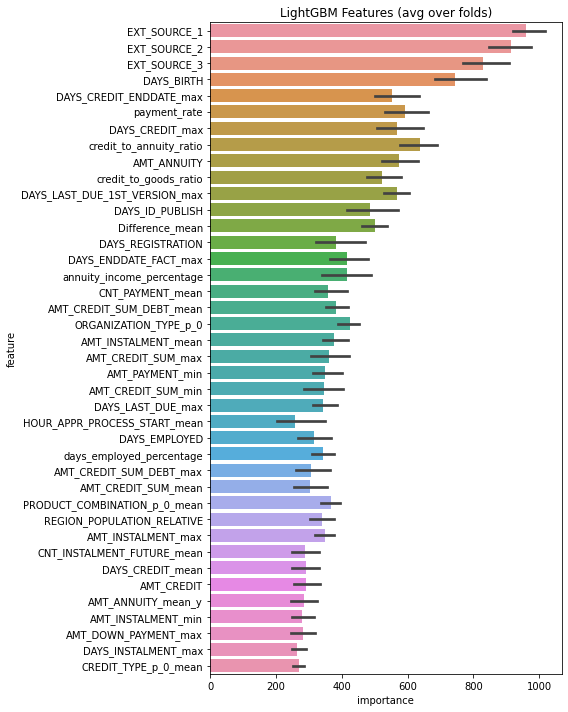

In [ ]:
feat_importance = kfold_lightgbm(train,test , num_folds= 5, stratified = True)